In [ ]:
!pip install -U -q tensorflow_datasets


In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
DATASET_PATH = 'data/'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'speech_commands_v0.02.tar.gz',
      origin="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir='data')

2428923189/2428923189 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [ ]:
# Constants
SAMPLE_RATE = 16000  # All audio files are in 16kHz
AUDIO_DURATION = 1   # Each audio is 1 second
SAMPLES_PER_TRACK = SAMPLE_RATE * AUDIO_DURATION
INPUT_SHAPE = (32, 32, 1)  # Input shape for CNN after converting to Mel-spectrogram

def load_audio_files(data_path):
    """Load audio files from the dataset directory and their corresponding labels, ignoring irrelevant files."""
    labels = []
    audio_data = []

    # Get sorted list of command directories (only folders)
    commands = [d for d in sorted(os.listdir(data_path)) if os.path.isdir(os.path.join(data_path, d))]
    print(f"Commands: {commands}")

    for label, command in enumerate(commands):
        command_path = os.path.join(data_path, command)
        if os.path.isdir(command_path):
            for audio_file in os.listdir(command_path):
                file_path = os.path.join(command_path, audio_file)

                # Check if the file is an audio file
                if not audio_file.endswith(('.wav', '.mp3')): # Add other audio extensions if needed
                    continue

                # Load audio file
                y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                # Ensure all audio clips are exactly 1 second long
                if len(y) >= SAMPLES_PER_TRACK:
                    y = y[:SAMPLES_PER_TRACK]  # Trim to 1 second
                else:
                    y = np.pad(y, (0, max(0, SAMPLES_PER_TRACK - len(y))), mode='constant')

                # Convert to Mel-spectrogram
                mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=32, fmax=8000)
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                # Resize and normalize the Mel-spectrogram to fit input shape
                mel_spec_db = np.expand_dims(mel_spec_db, axis=-1) # Add a channel dimension
                mel_spec_db = tf.image.resize(mel_spec_db, (32, 32))
                mel_spec_db = mel_spec_db.numpy().reshape(32, 32, 1)  # Add channel dimension

                # Store data and label
                audio_data.append(mel_spec_db)
                labels.append(label)

    return np.array(audio_data), np.array(labels), commands

In [ ]:
# Load dataset
data_path = "data"  # Path to the extracted dataset directory
audio_data, labels, commands = load_audio_files(data_path)

Commands: ['_background_noise_', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [ ]:
# Normalize data
audio_data = audio_data / 255.0

In [ ]:
# Split data into train, validation, and test sets
train_data, test_data, train_labels, test_labels = train_test_split(audio_data, labels, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [ ]:
# Convert labels to categorical format for training
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=len(commands))
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=len(commands))
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=len(commands))

In [ ]:
print(f"Train Data Shape: {train_data.shape}")


Train Data Shape: (67734, 32, 32, 1)


In [ ]:
print(f"Validation Data Shape: {val_data.shape}")


Validation Data Shape: (16934, 32, 32, 1)


In [ ]:
print(f"Test Data Shape: {test_data.shape}")

Test Data Shape: (21167, 32, 32, 1)


In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# To display inline plots
%matplotlib inline

# Constants
DATASET_PATH = 'data/'
SAMPLE_RATE = 16000
AUDIO_DURATION = 1
SAMPLES_PER_TRACK = SAMPLE_RATE * AUDIO_DURATION


In [ ]:
def plot_waveform(y, sr, title="Waveform"):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()


In [ ]:
def plot_melspectrogram(y, sr, n_mels=32, fmax=8000, title="Mel-Spectrogram"):
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', fmax=fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()


In [ ]:
def plot_class_distribution(labels, commands):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=labels, palette="viridis")
    plt.title('Class Distribution')
    plt.xlabel('Command')
    plt.ylabel('Count')
    plt.xticks(ticks=np.arange(len(commands)), labels=commands, rotation=45)
    plt.show()


In [ ]:
import random

# Load a sample audio file from each command for visualization
def visualize_samples(data_path, commands):
    for command in commands:
        command_path = os.path.join(data_path, command)
        sample_file = random.choice(os.listdir(command_path))
        file_path = os.path.join(command_path, sample_file)

        if file_path.endswith(('.wav', '.mp3')):
            # Load audio file
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

            # Plot Waveform
            plot_waveform(y, sr, title=f"Waveform of {command} - {sample_file}")

            # Plot Mel-Spectrogram
            plot_melspectrogram(y, sr, title=f"Mel-Spectrogram of {command} - {sample_file}")


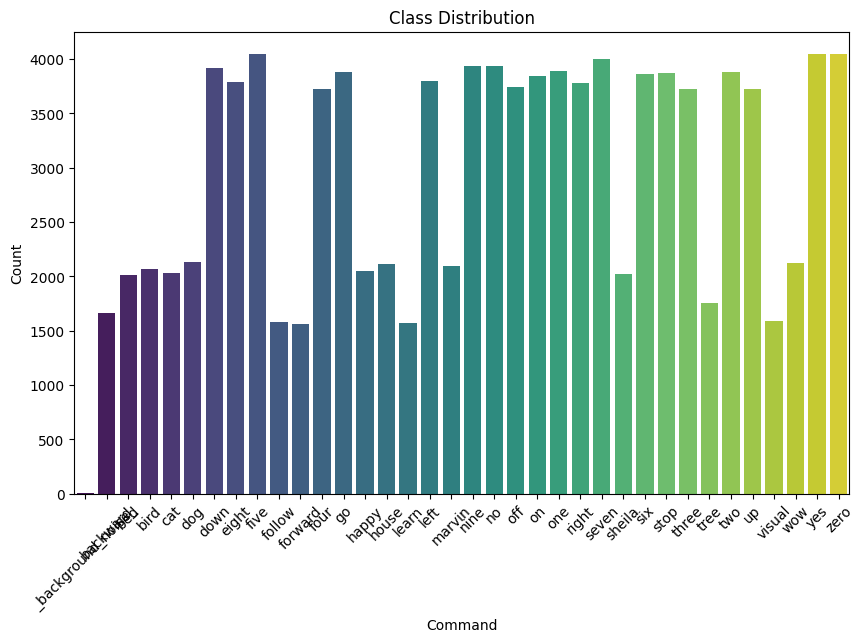

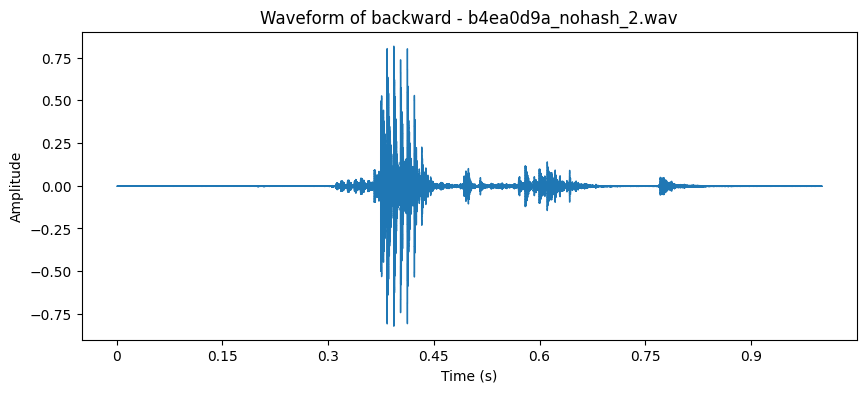

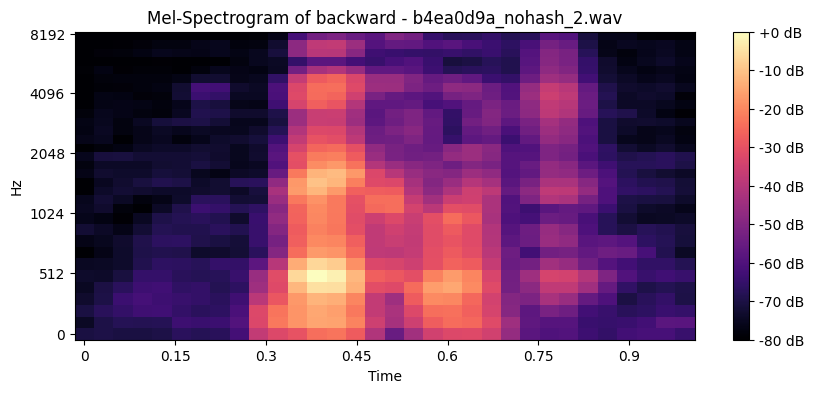

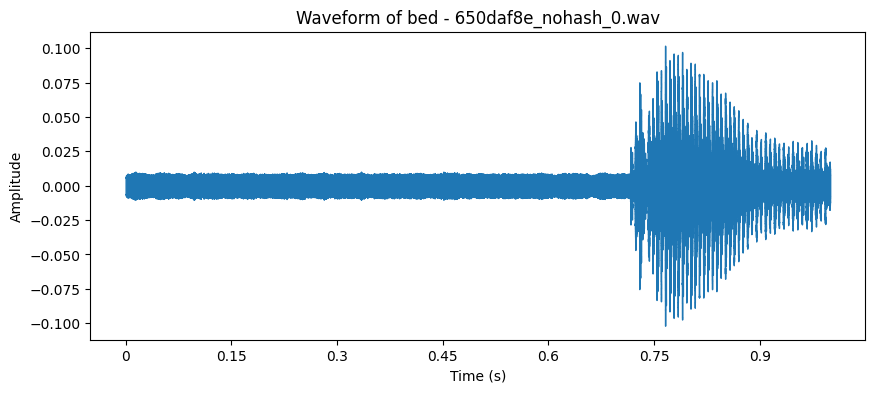

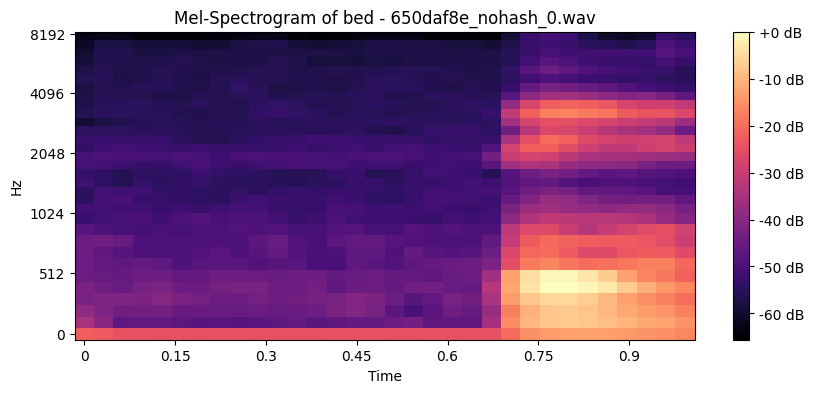

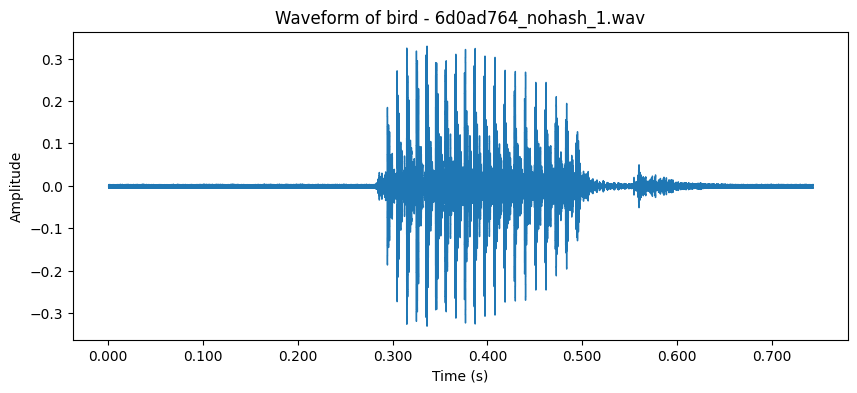

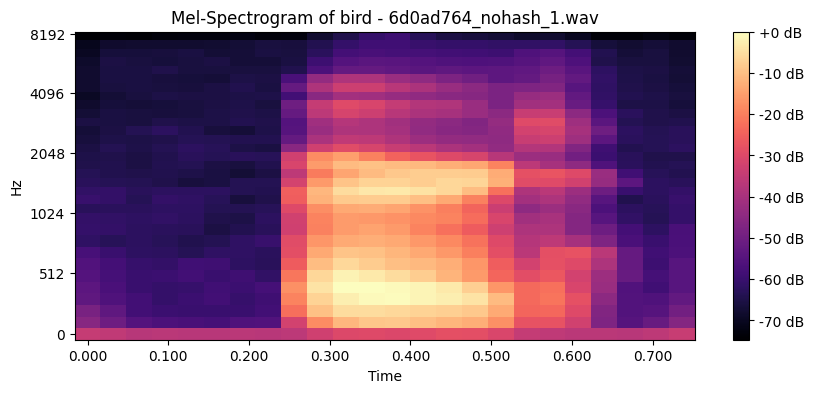

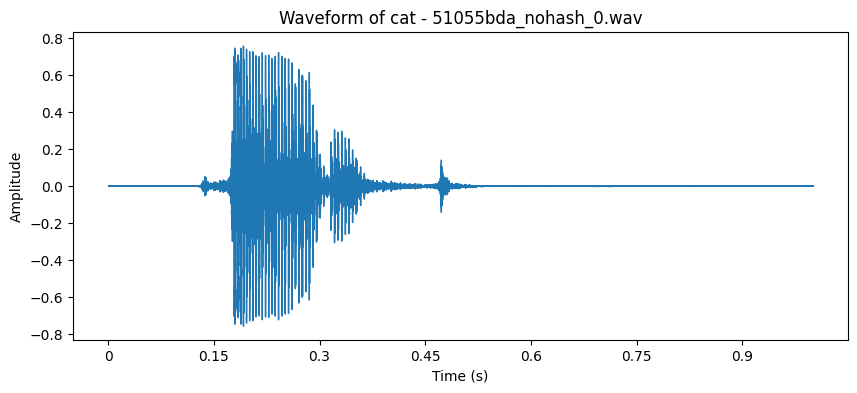

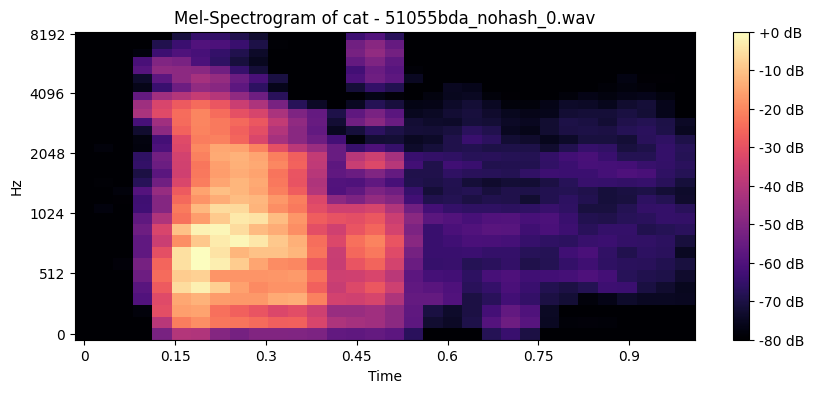

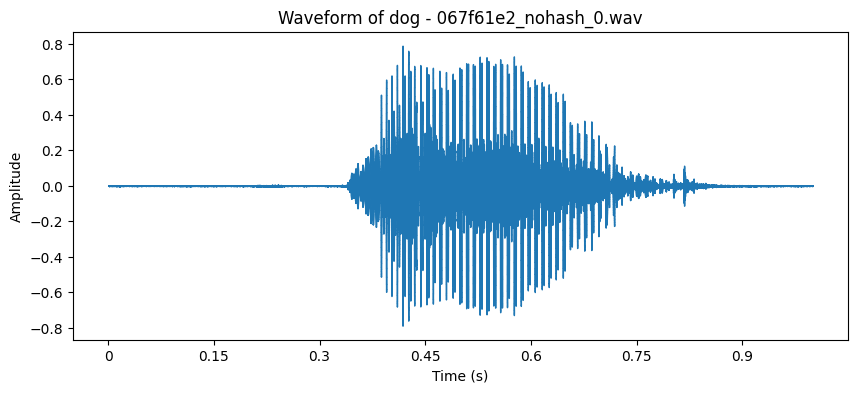

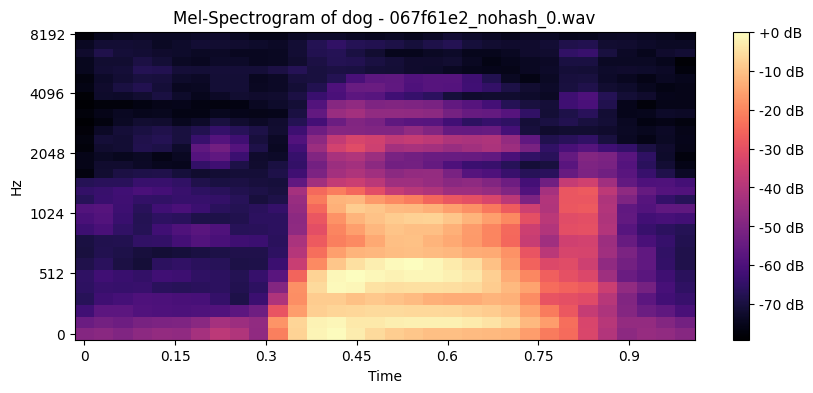

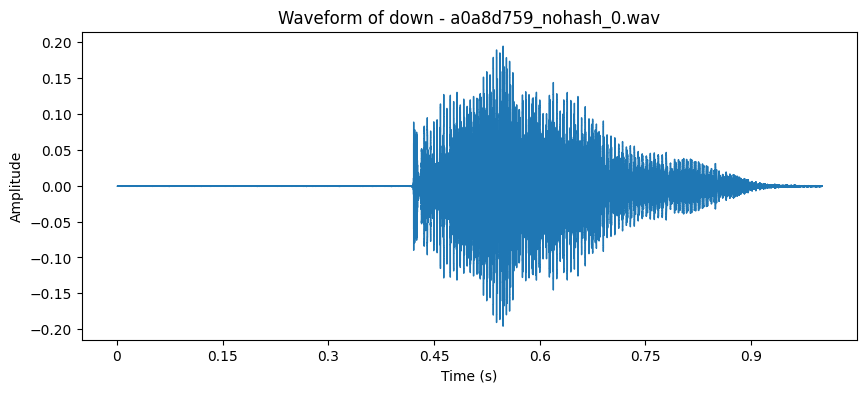

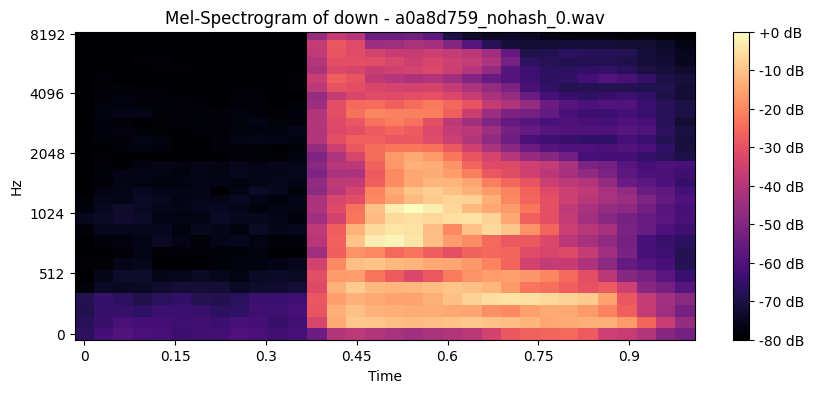

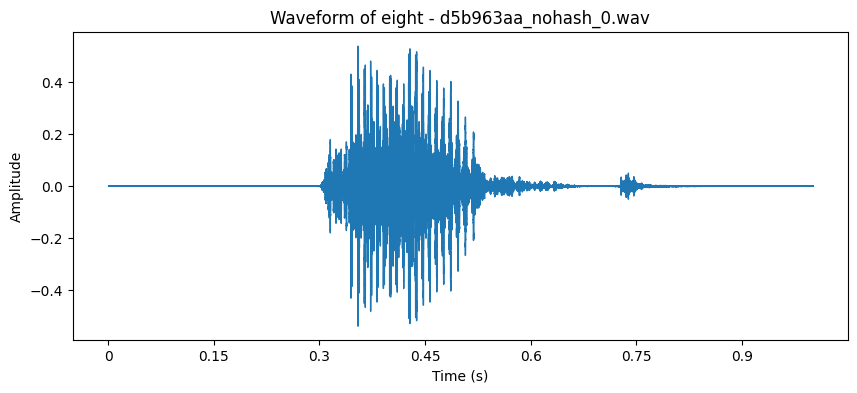

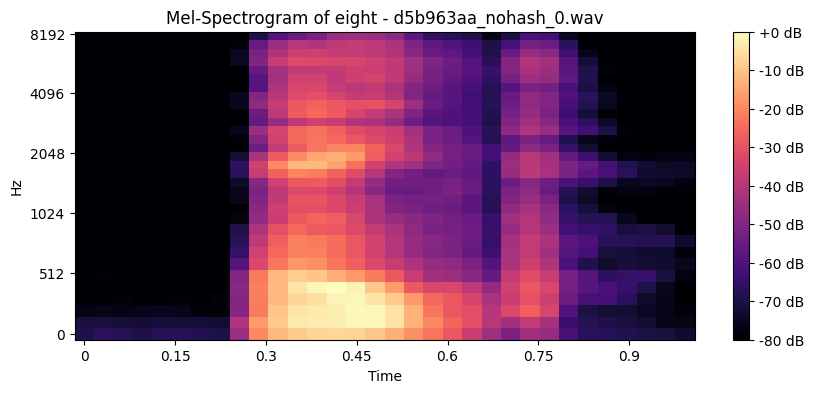

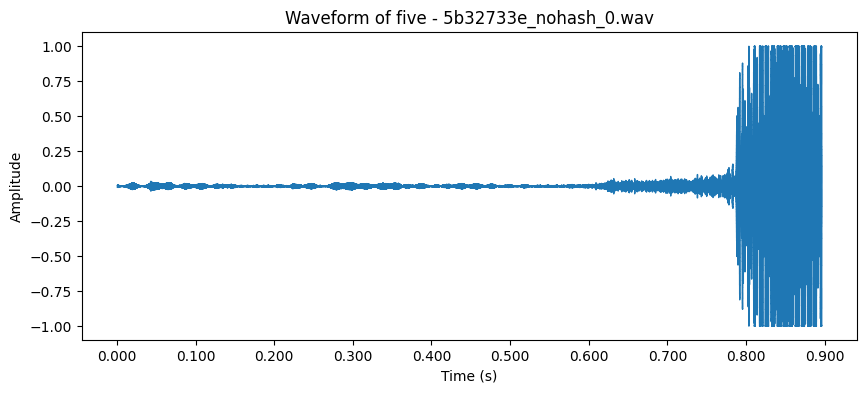

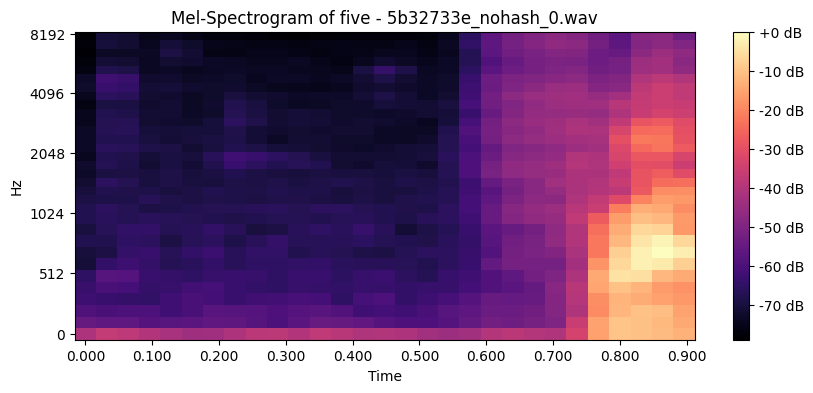

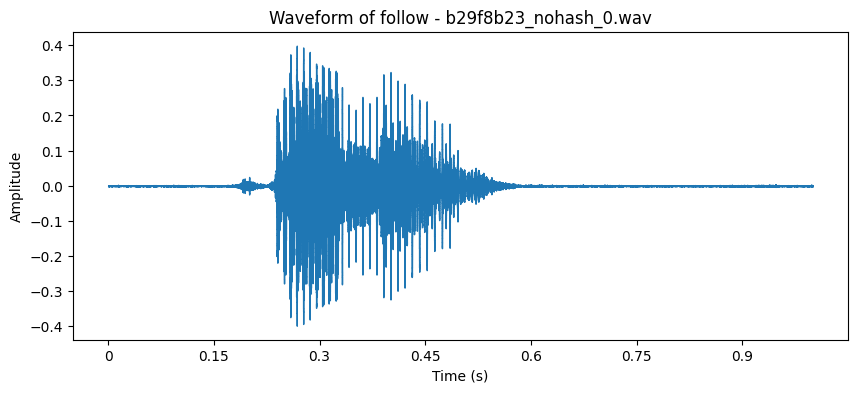

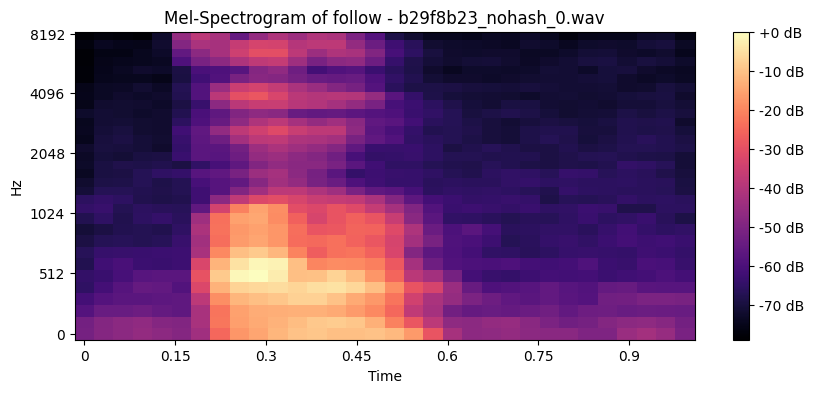

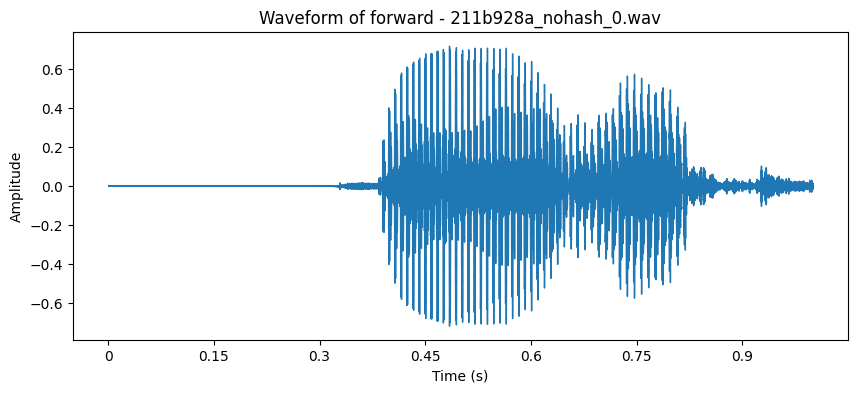

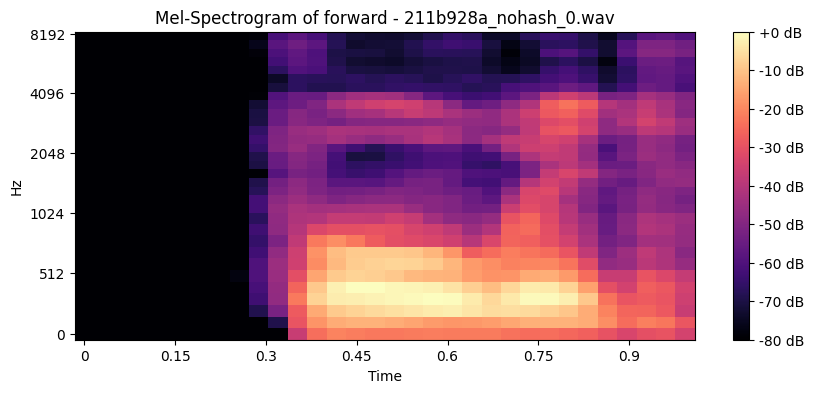

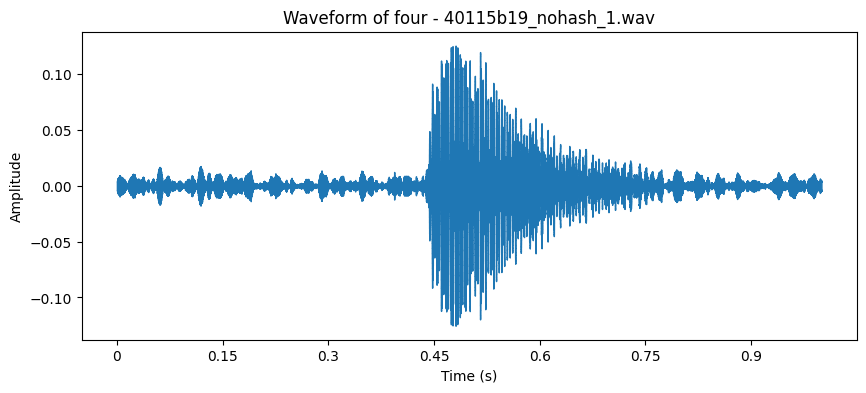

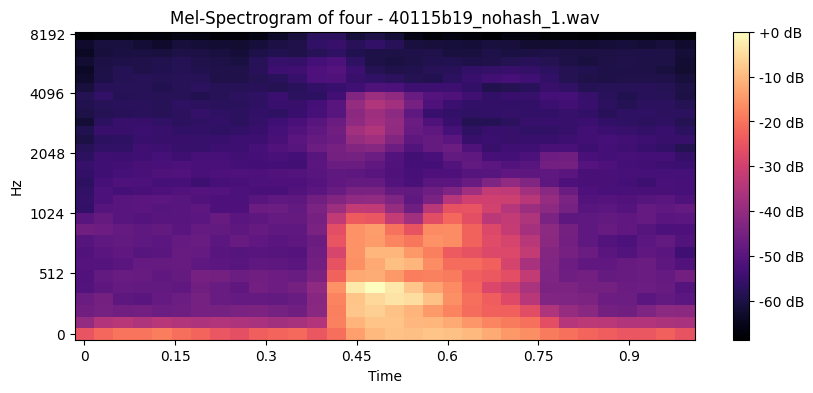

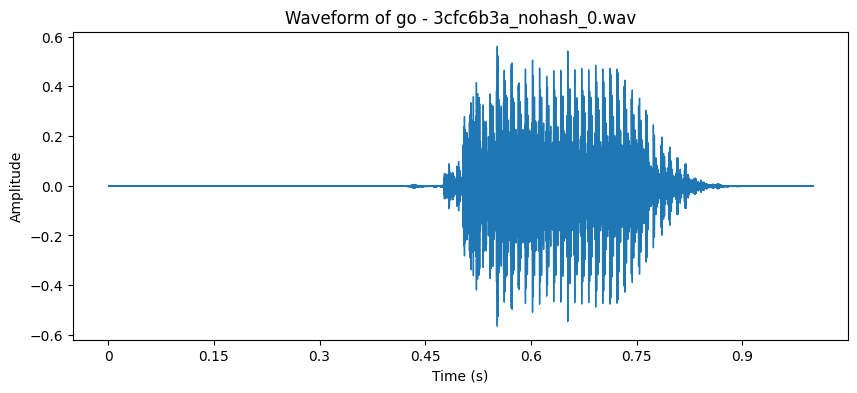

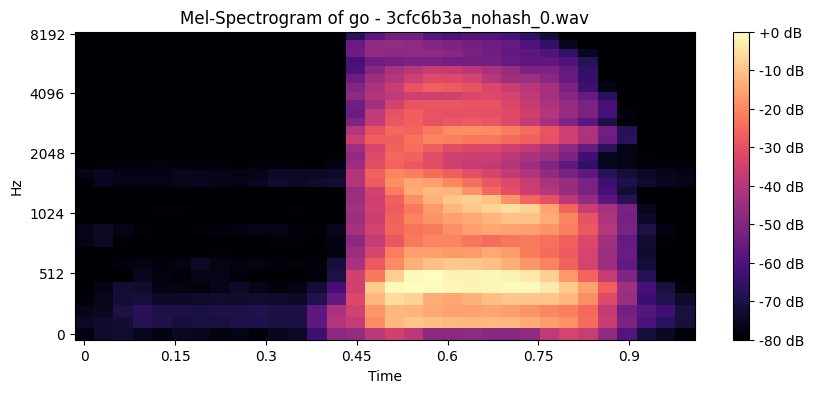

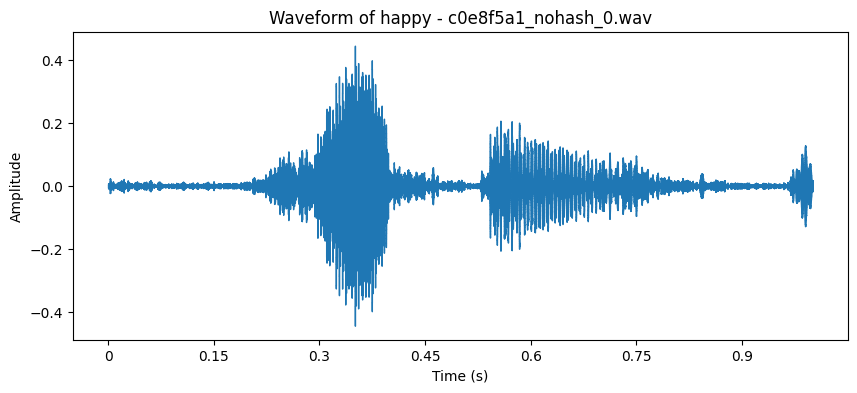

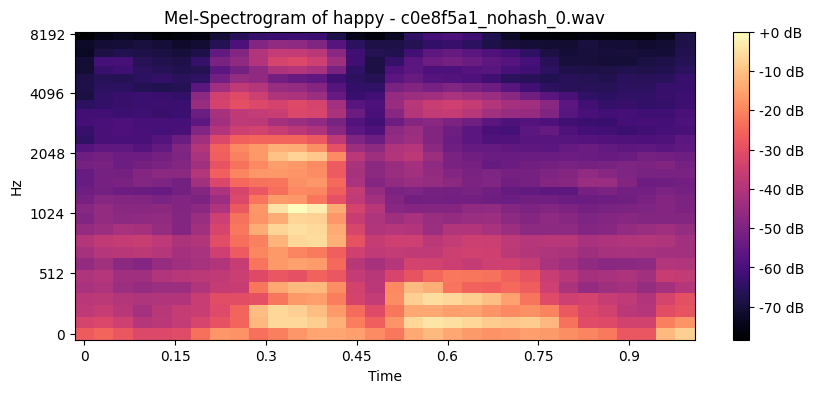

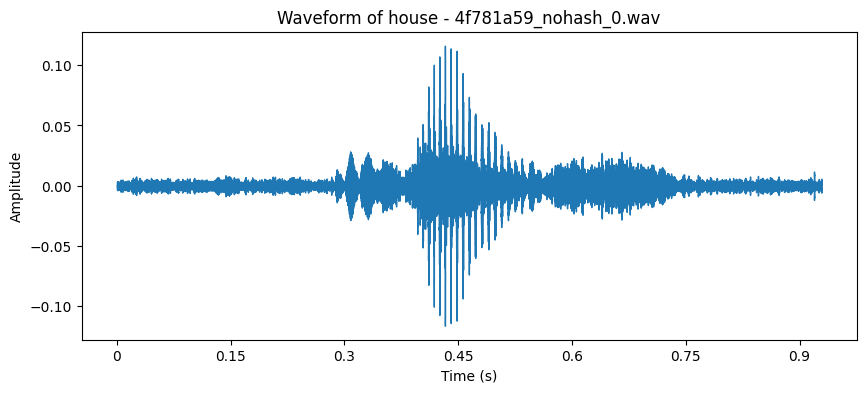

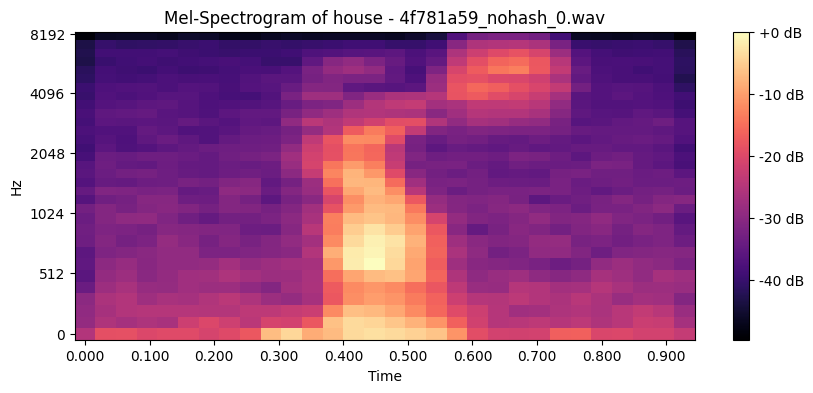

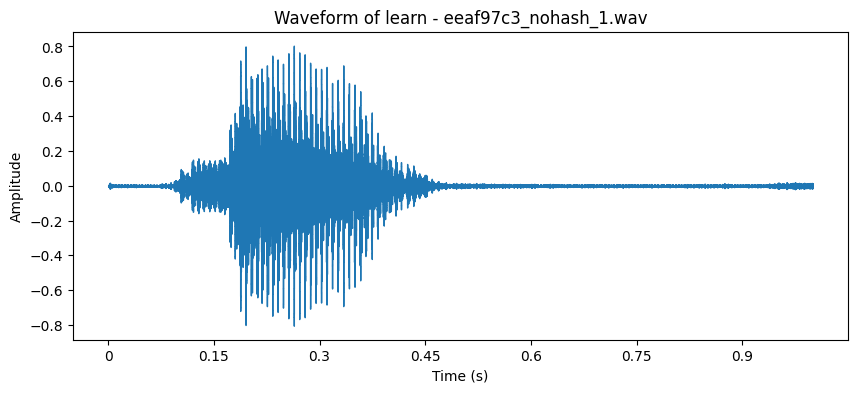

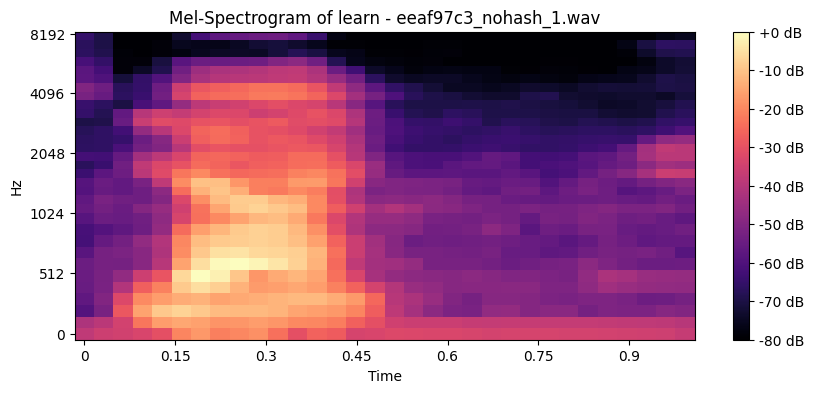

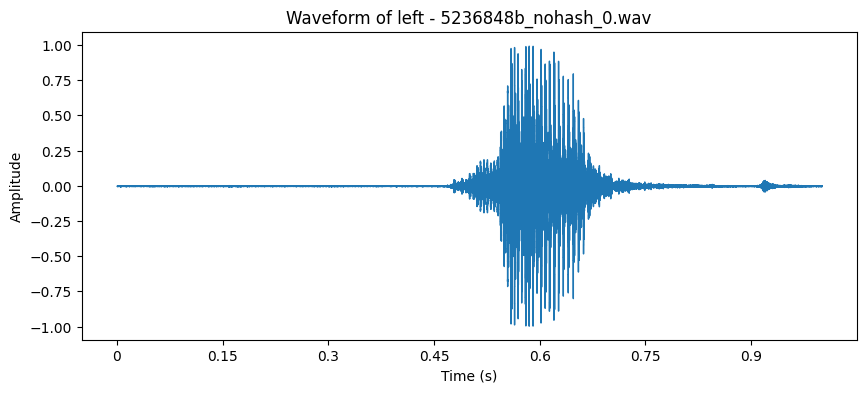

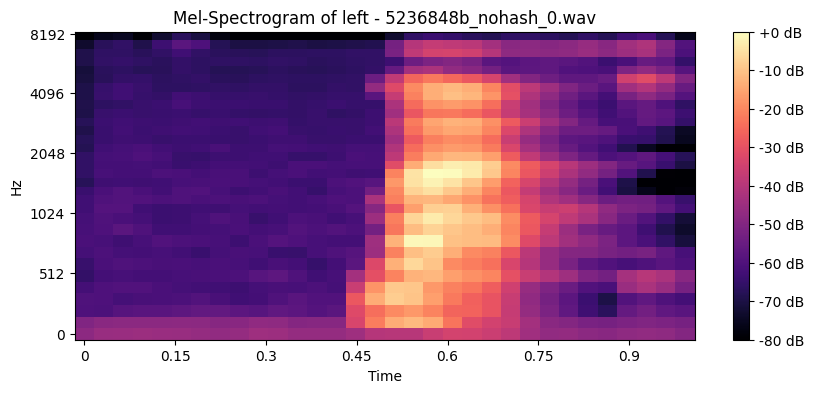

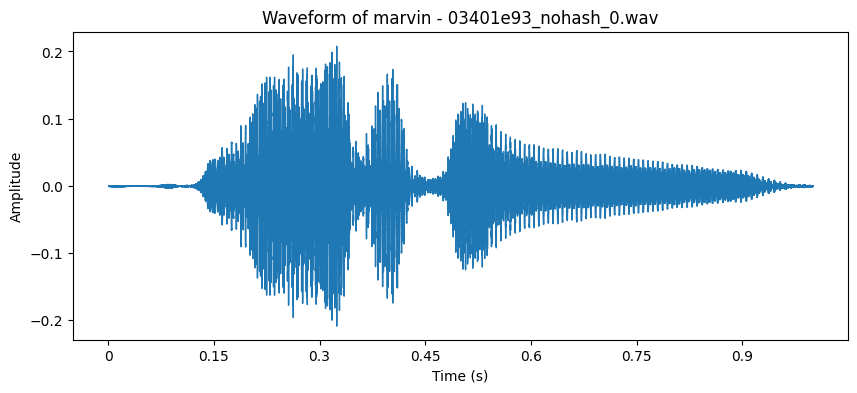

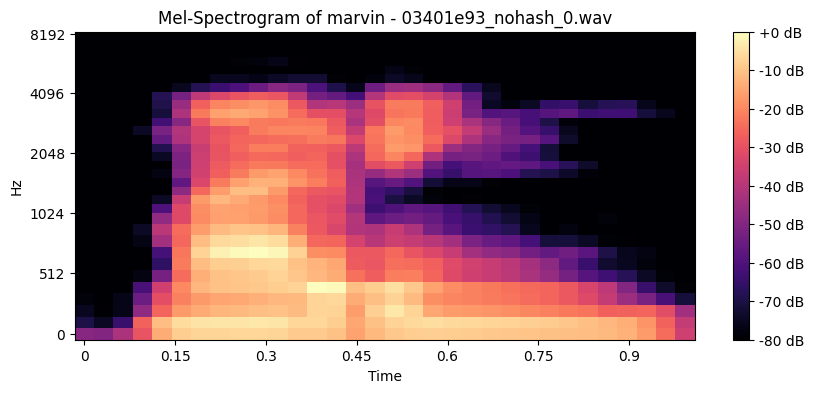

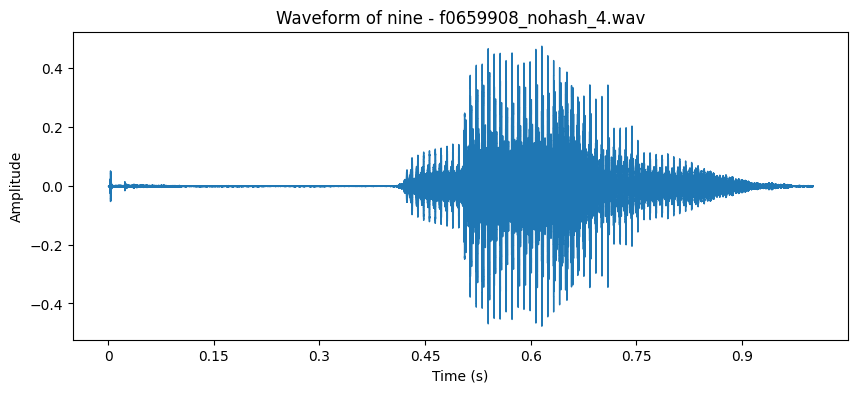

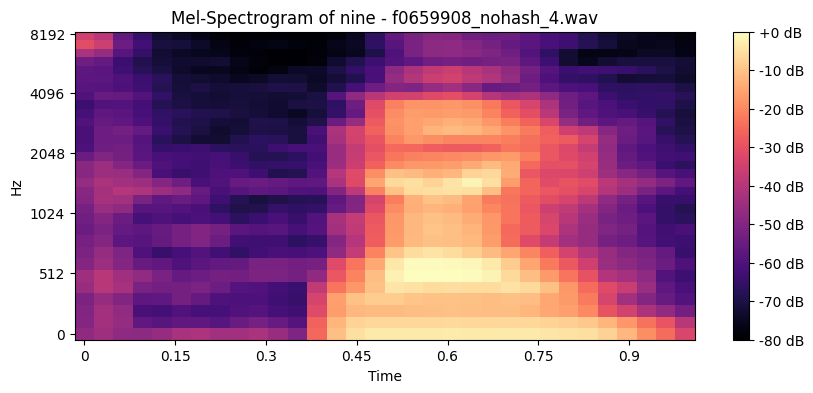

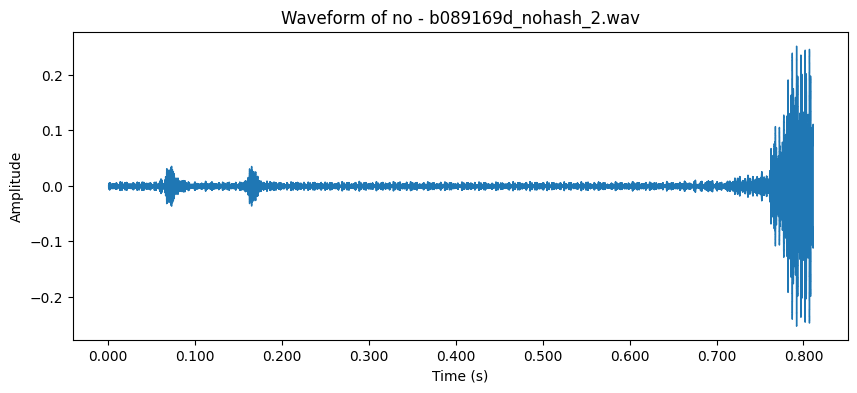

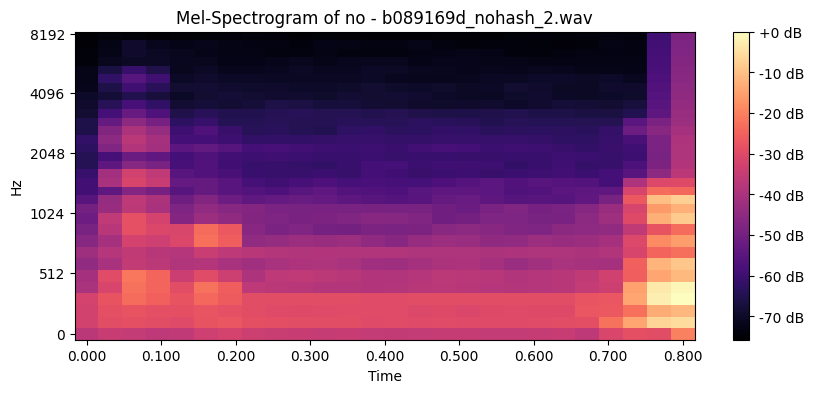

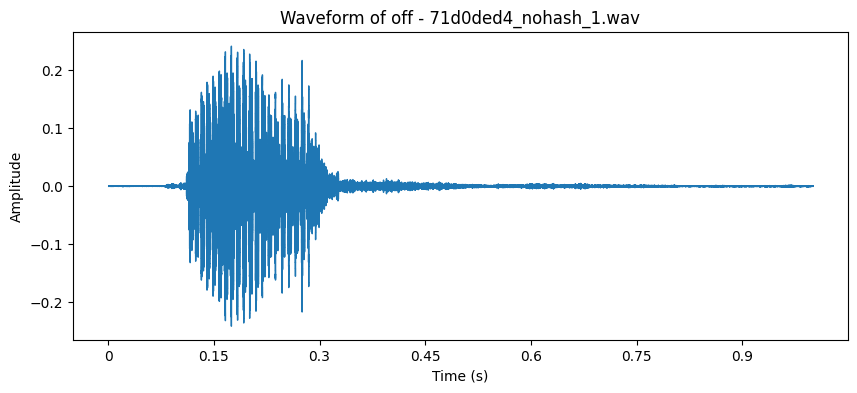

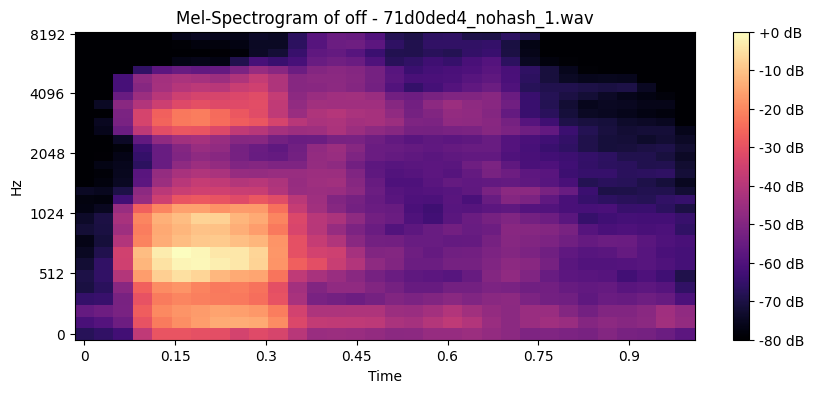

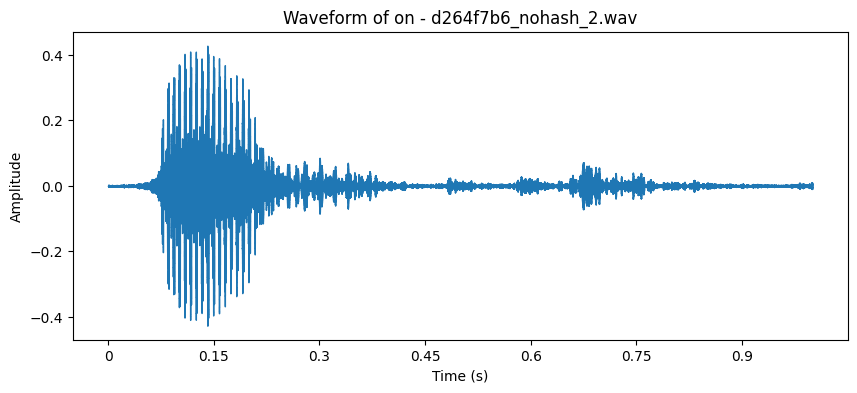

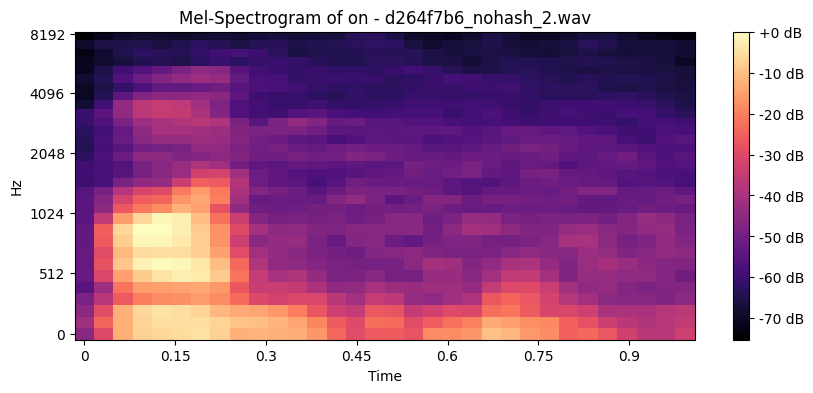

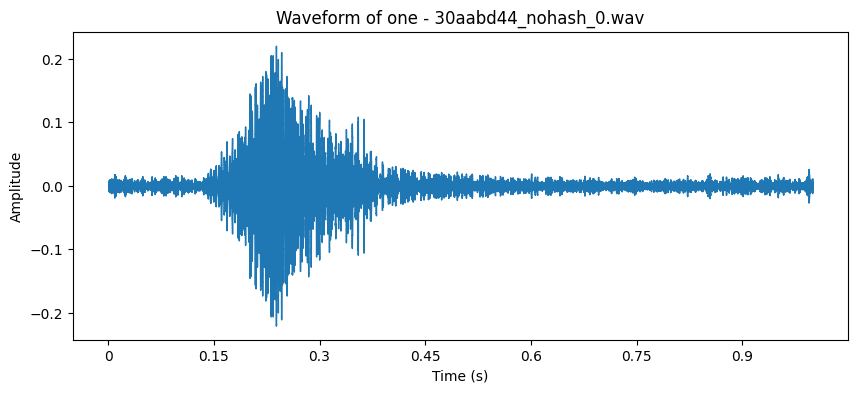

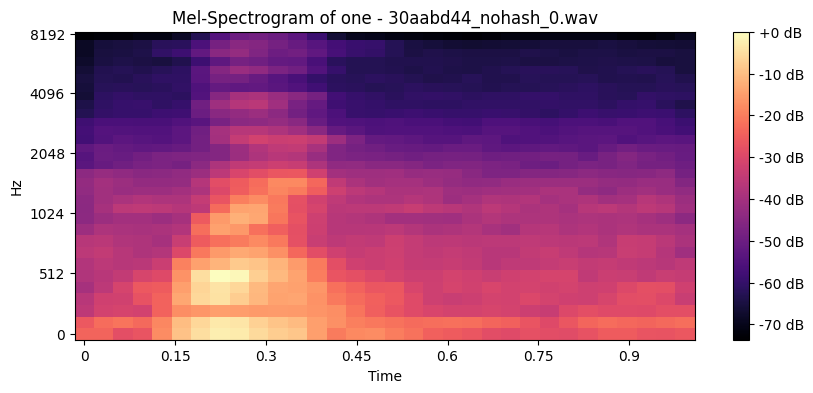

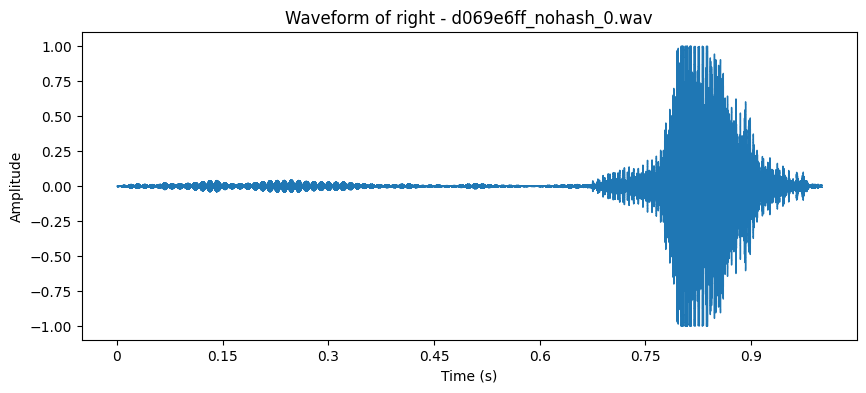

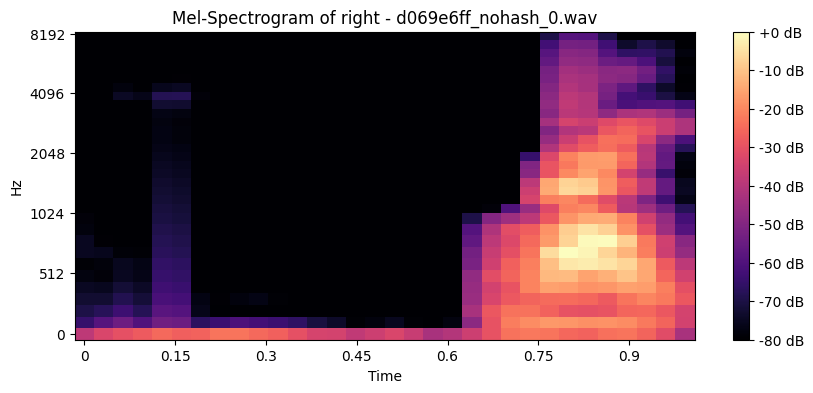

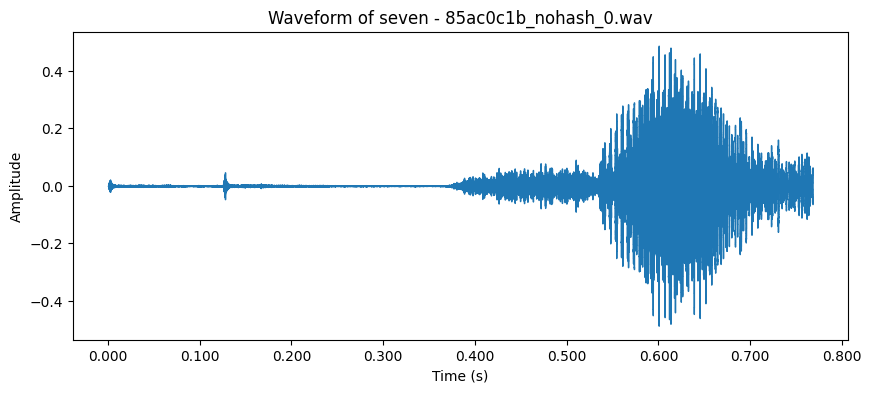

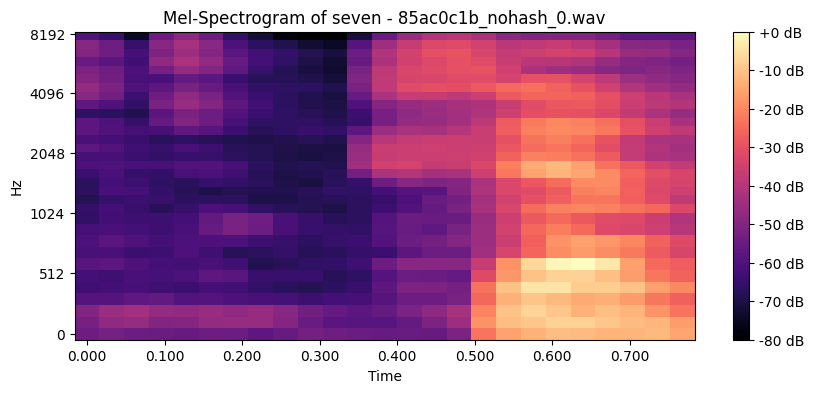

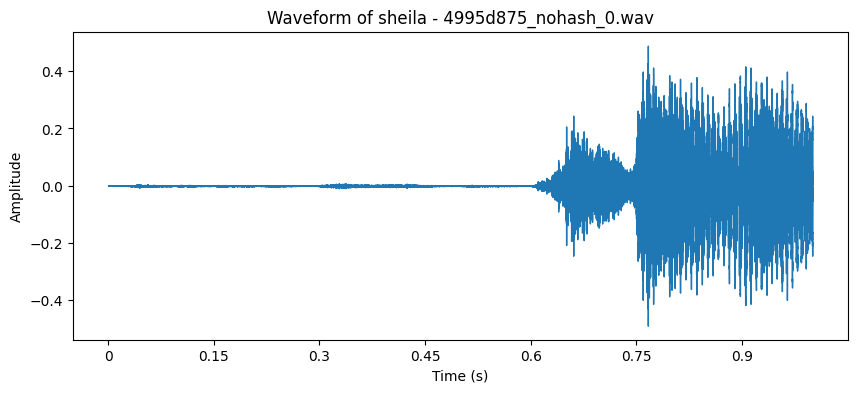

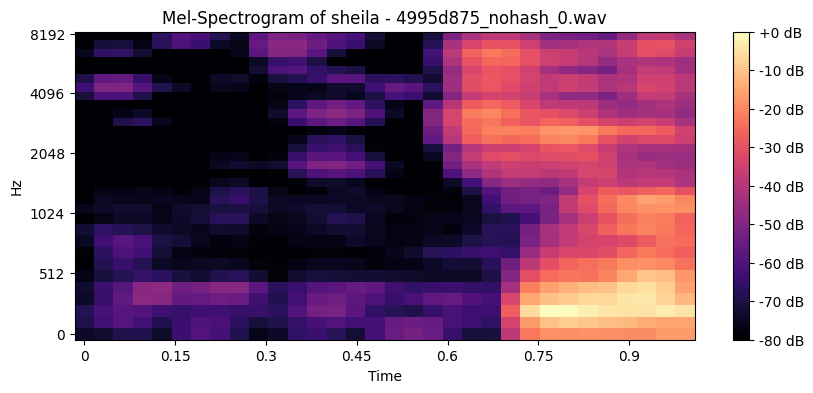

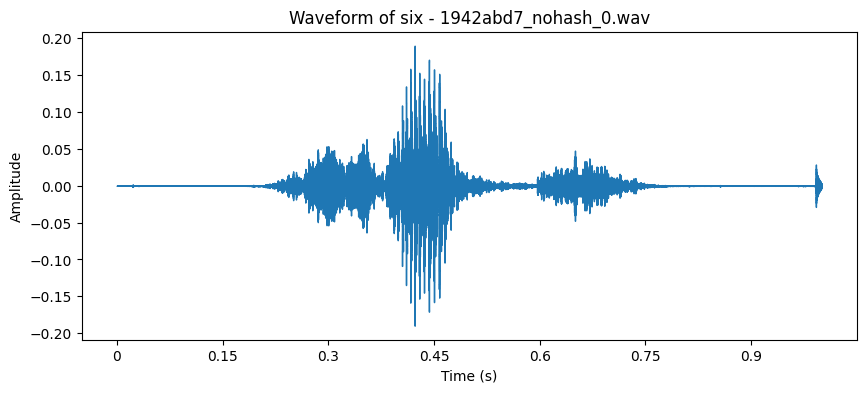

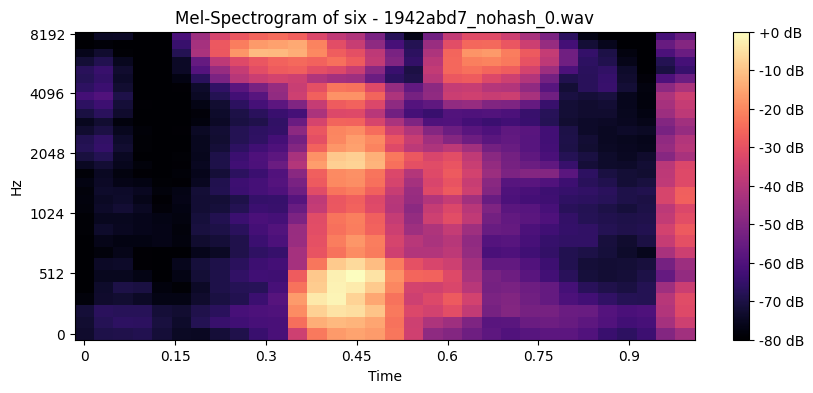

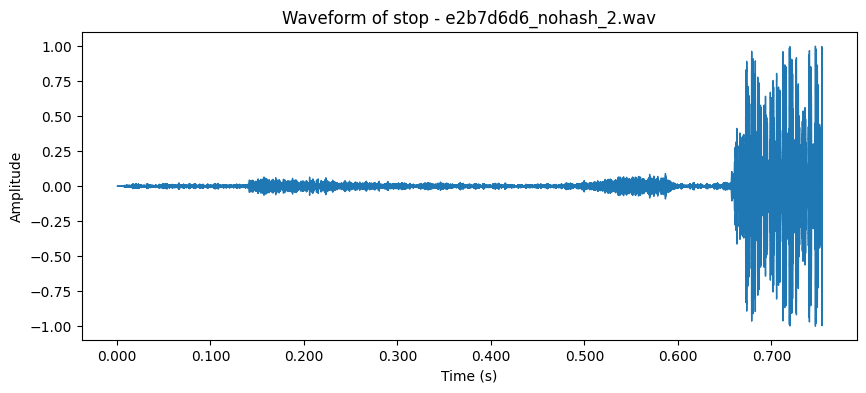

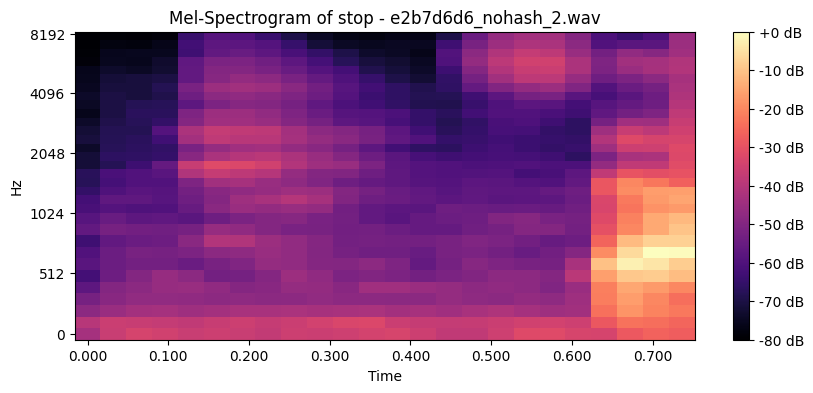

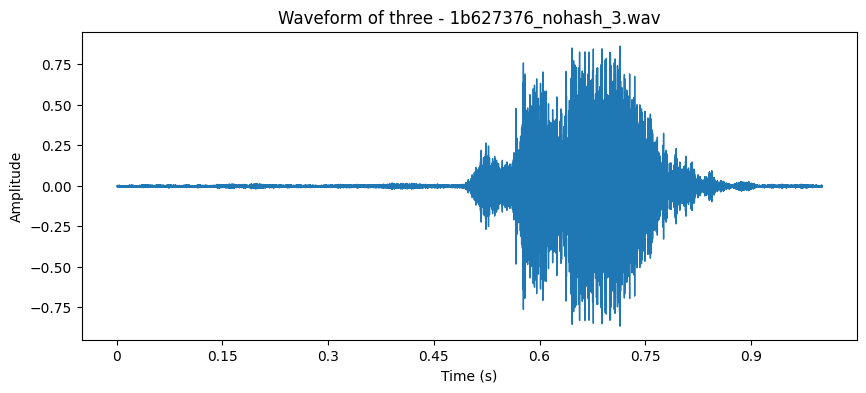

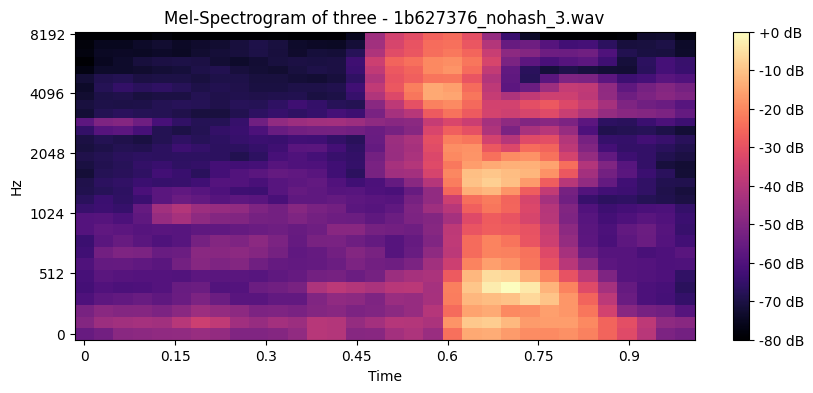

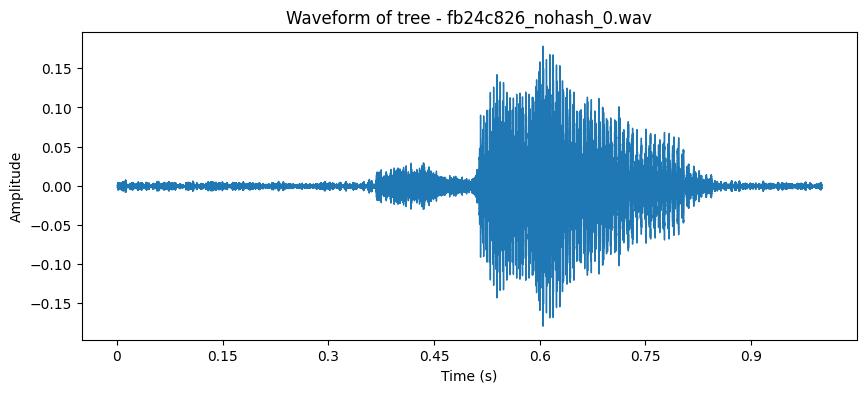

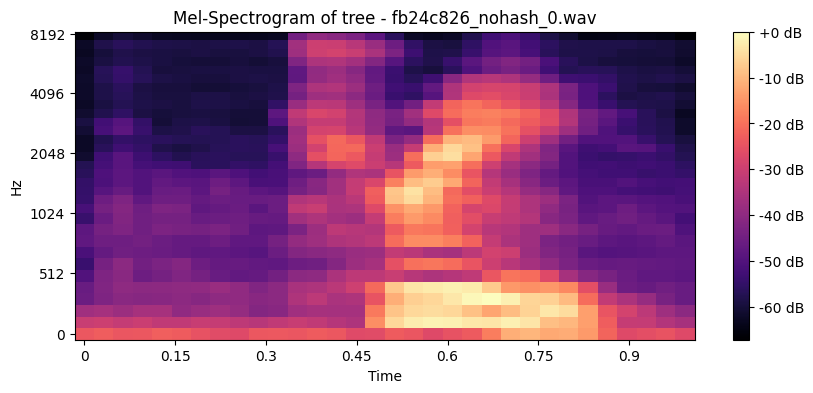

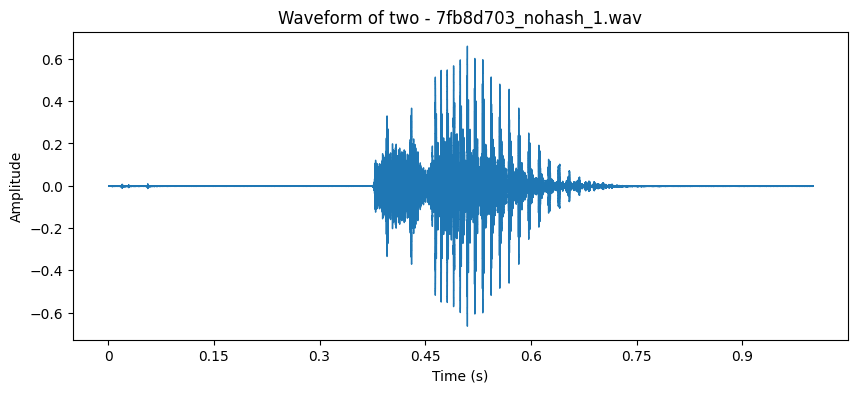

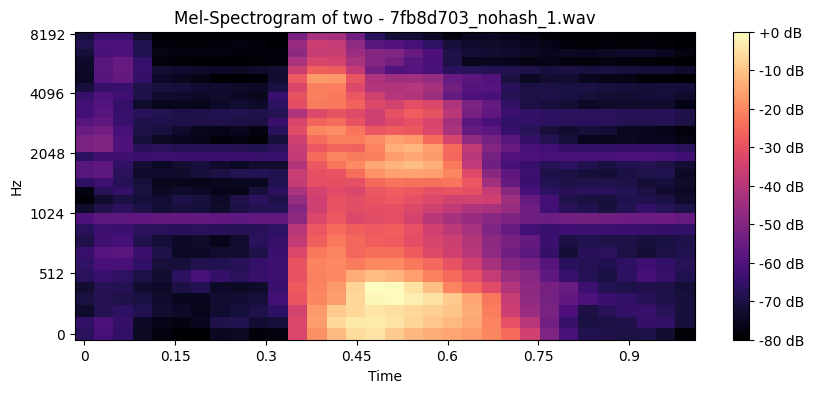

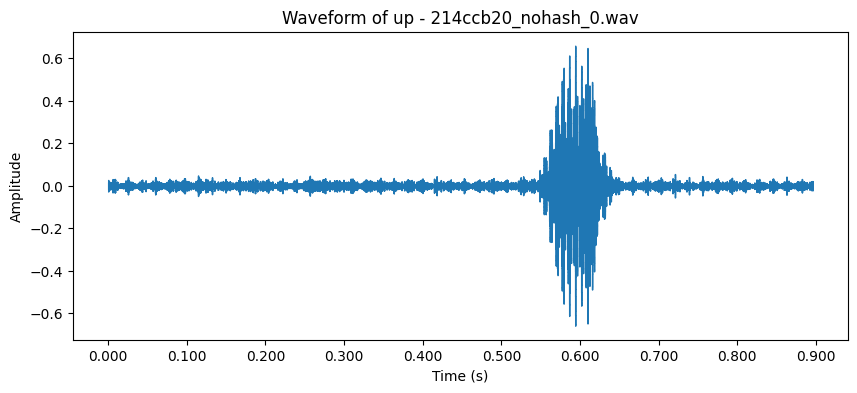

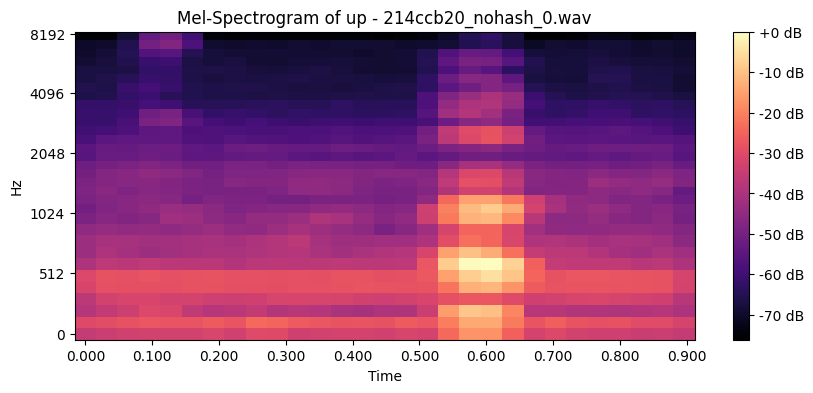

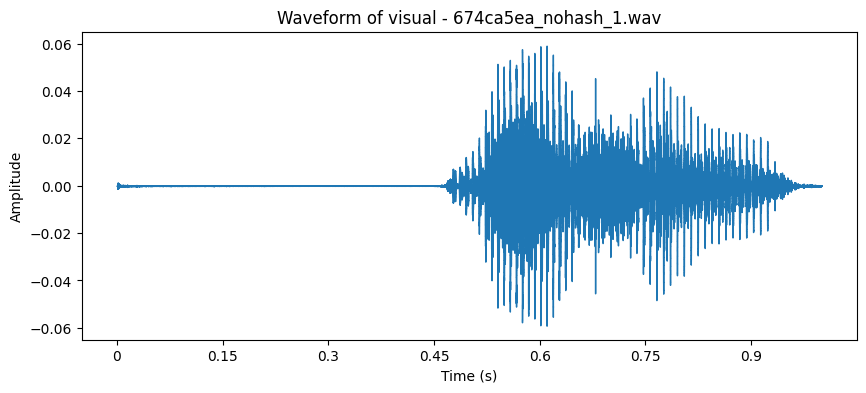

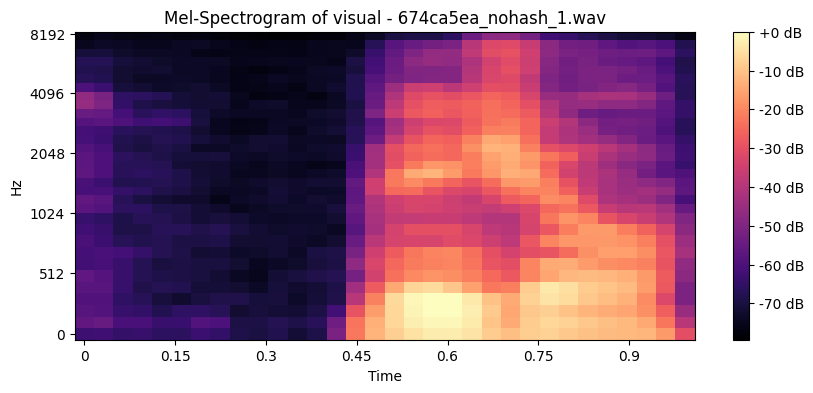

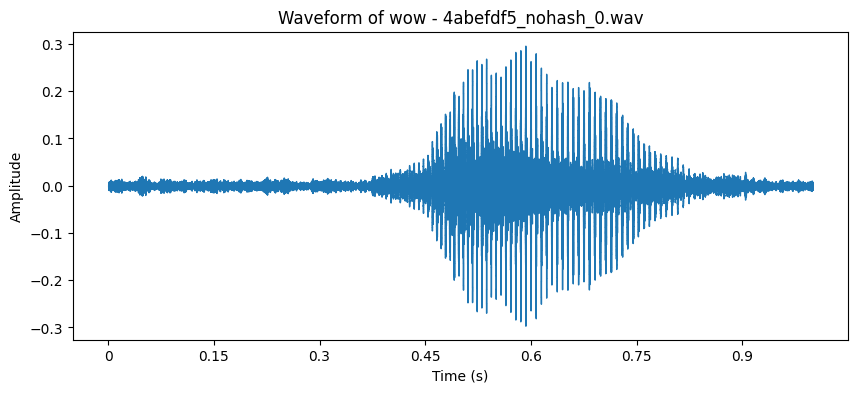

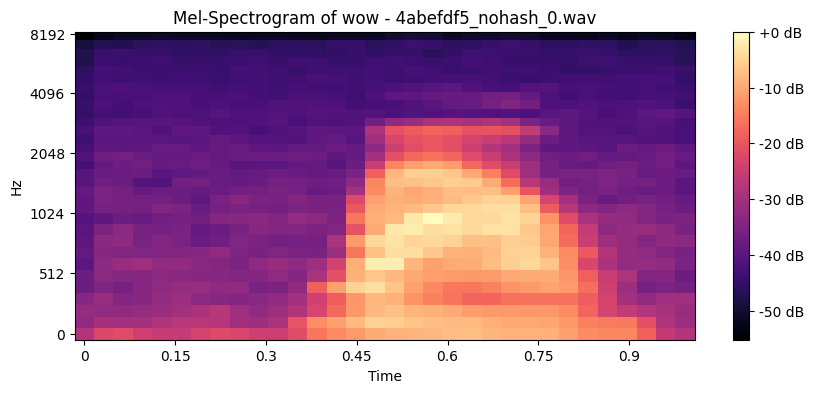

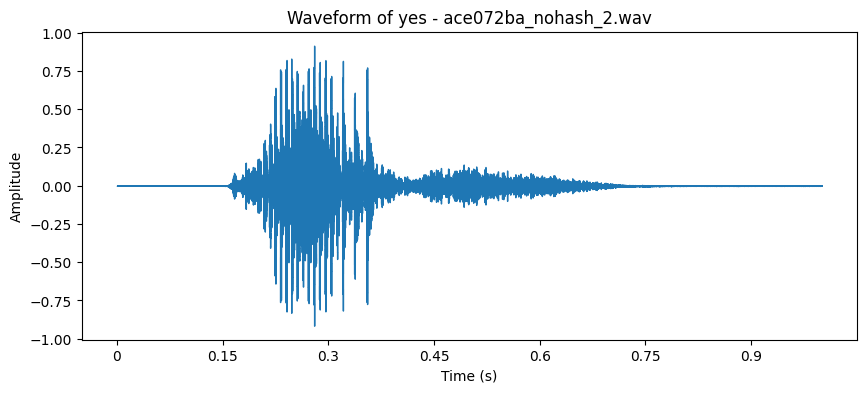

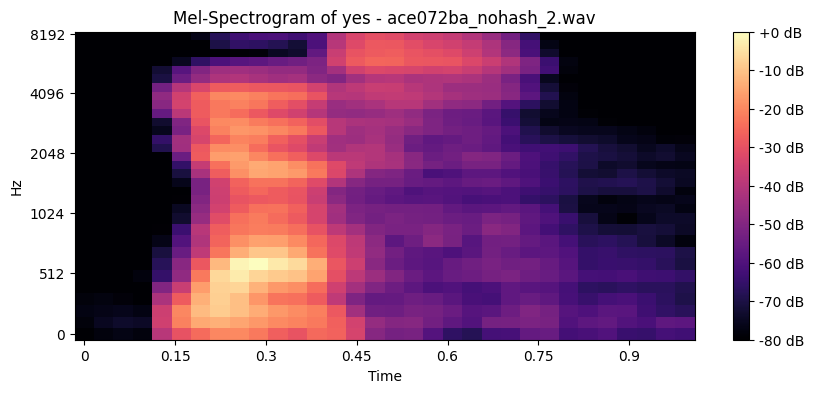

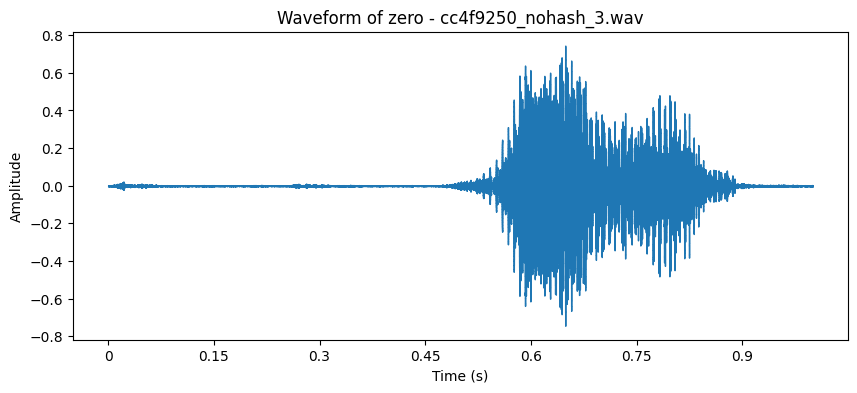

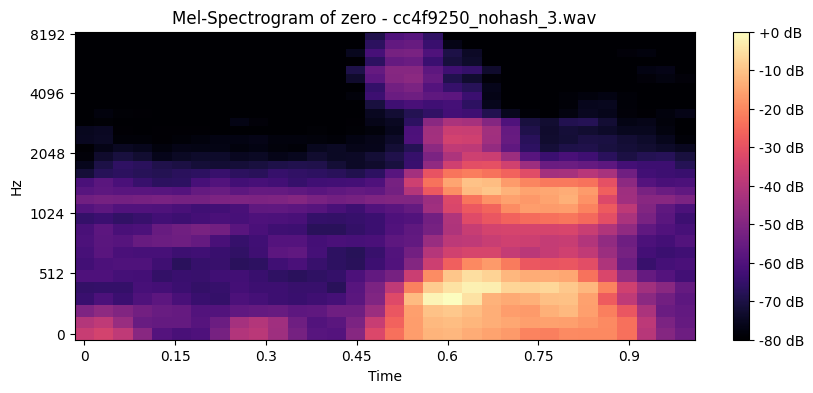

In [ ]:
# Plot the class distribution
plot_class_distribution(labels, commands)

# Visualize sample waveforms and mel-spectrograms
visualize_samples(data_path, commands)


In [ ]:
def add_noise(y, noise_factor=0.005):
    """Add random noise to audio data."""
    noise = np.random.randn(len(y))
    augmented_data = y + noise_factor * noise
    return augmented_data


SAMPLE_RATE = 22050
def shift_pitch(y, n_steps=2): # Removed sr argument
    """Shift pitch of the audio data."""
    return librosa.effects.pitch_shift(y, sr=SAMPLE_RATE, n_steps=n_steps) # sr is now a keyword argument




In [ ]:
# Augment the dataset
augmented_data = []
augmented_labels = []

for i in range(len(train_data)):
    # Original data
    augmented_data.append(train_data[i])
    augmented_labels.append(train_labels[i])

    # Add noise
    noise_data = add_noise(train_data[i].flatten())
    augmented_data.append(noise_data.reshape(32, 32, 1))
    augmented_labels.append(train_labels[i])

    # Shift pitch
    pitch_data = shift_pitch(train_data[i].flatten()) # Removed SAMPLE_RATE argument
    augmented_data.append(pitch_data.reshape(32, 32, 1))
    augmented_labels.append(train_labels[i])

augmented_data = np.array(augmented_data)
augmented_labels = np.array(augmented_labels)

/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


In [ ]:
# Build the CNN model with Dropout layers
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(commands), activation='softmax')  # Output layer
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(augmented_data, augmented_labels, epochs=40,
                    validation_data=(val_data, val_labels),
                    batch_size=32, callbacks=[early_stopping])

Epoch 1/40
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.2969 - loss: 2.3875 - val_accuracy: 0.5133 - val_loss: 1.7782
Epoch 2/40
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.3616 - loss: 2.1570 - val_accuracy: 0.5675 - val_loss: 1.5642
Epoch 3/40
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.4066 - loss: 1.9963 - val_accuracy: 0.6036 - val_loss: 1.4250
Epoch 4/40
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.4460 - loss: 1.8659 - val_accuracy: 0.6369 - val_loss: 1.3032
Epoch 5/40
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.4738 - loss: 1.7673 - val_accuracy: 0.6646 - val_loss: 1.2052
Epoch 6/40
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5004 - loss: 1.6803 - val_accuracy: 0.6876 - val_loss: 1.1315
Epoch 7/40
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5186 - loss: 1.6101 - val_accuracy: 0.7050 - val_loss: 1.0513
Epoch 8/40
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5390 - loss: 1

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_data, test_labels)
print(f"Test Accuracy after fine-tuning: {test_acc:.2f}")

662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8554 - loss: 0.4884
Test Accuracy after fine-tuning: 0.86


In [ ]:
model2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(commands), activation='softmax')  # Output layer
])

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history2 = model2.fit(train_data, train_labels, epochs=30,
                    validation_data=(val_data, val_labels),
                    batch_size=32, callbacks=[early_stopping])

Epoch 1/30
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.1034 - loss: 3.2222 - val_accuracy: 0.5135 - val_loss: 1.7374
Epoch 2/30
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3888 - loss: 2.0033 - val_accuracy: 0.6412 - val_loss: 1.2258
Epoch 3/30
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5049 - loss: 1.6241 - val_accuracy: 0.7109 - val_loss: 0.9953
Epoch 4/30
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5675 - loss: 1.4165 - val_accuracy: 0.7460 - val_loss: 0.8793
Epoch 5/30
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6059 - loss: 1.2850 - val_accuracy: 0.7820 - val_loss: 0.7654


In [ ]:
model3 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(commands), activation='softmax')  # Output layer
])

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history3 = model3.fit(train_data, train_labels, epochs=30,
                    validation_data=(val_data, val_labels),
                    batch_size=32, callbacks=[early_stopping])

Epoch 1/30
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.2136 - loss: 2.8081 - val_accuracy: 0.5943 - val_loss: 1.3874
Epoch 2/30
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6405 - loss: 1.2076 - val_accuracy: 0.7164 - val_loss: 0.9621
Epoch 3/30
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7331 - loss: 0.8854 - val_accuracy: 0.7661 - val_loss: 0.7923
Epoch 4/30
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7750 - loss: 0.7370 - val_accuracy: 0.7881 - val_loss: 0.7115
Epoch 5/30
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8011 - loss: 0.6496 - val_accuracy: 0.8013 - val_loss: 0.6590


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_data, test_labels)
print(f"Test Accuracy: {test_acc:.2f}")

662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8554 - loss: 0.4884
Test Accuracy: 0.86


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model3.evaluate(test_data, test_labels)
print(f"Test Accuracy: {test_acc:.2f}")

662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5975 - loss: 1.3660
Test Accuracy: 0.60


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model2.evaluate(test_data, test_labels)
print(f"Test Accuracy: {test_acc:.2f}")

662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5098 - loss: 1.7289
Test Accuracy: 0.51


In [ ]:
model4 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(commands), activation='softmax')  # Output layer
])

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history4 = model4.fit(augmented_data, augmented_labels, epochs=30,
                    validation_data=(val_data, val_labels),
                    batch_size=32, callbacks=[early_stopping])

Epoch 1/30
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.3183 - loss: 2.3821 - val_accuracy: 0.6870 - val_loss: 1.0561
Epoch 2/30
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6886 - loss: 1.0415 - val_accuracy: 0.7634 - val_loss: 0.7911
Epoch 3/30
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7501 - loss: 0.8311 - val_accuracy: 0.7910 - val_loss: 0.6992
Epoch 4/30
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7794 - loss: 0.7284 - val_accuracy: 0.8100 - val_loss: 0.6350
Epoch 5/30
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7995 - loss: 0.6621 - val_accuracy: 0.8235 - val_loss: 0.5909


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model4.evaluate(test_data, test_labels)
print(f"Test Accuracy: {test_acc:.2f}")

662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6924 - loss: 1.0339
Test Accuracy: 0.69


# As we can see that the model1 gives the best result, so we will choose Model1

In [ ]:
model.save("/kaggle/working/model.h5")

In [ ]:
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=commands, yticklabels=commands)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [ ]:
print(classification_report(true_labels, predicted_labels, target_names=commands))
